# SGD, Batch Size, and Moment

Gradient descent is the primary optimziation algorithm used in deep learning.
However, the classic gradient descent is very slow as it computes gradient using the whole dataset.
Stochastic gradient descent is a fast version.
However, SGD has its own limitations.
In this tutorial, we will explore SGD and moment.

## Outcome

In this tutorial, you will.
- the impact of batch size in SGD
- Improve SGD with momentum

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import random

seed = 1234
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

### Load Dataset

We focus on MNIST dataset and load the dataset.

In [2]:
# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           download=True,
                                           transform=transforms.ToTensor())

# take 5000 samples out of 60,000 images
train_dataset = torch.utils.data.Subset(train_dataset, range(5000))
# Normalize the pixel values
train_dataset.transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307, ), (0.3081, ))])

`Dataloader` is able to split the data to facilate SGD.
We can tune the batch size in `Dataloader`.
To explore the impact of batch size, we define a function.

In [3]:
def train_with_batchsize(train_dataset, batch_size, device, max_epoch):
    train_avg_loss_by_epoch = []
    train_loss_by_batch = []
    train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=4)

    mlp = torch.nn.Sequential(nn.Flatten(start_dim=1, end_dim=-1),
                              torch.nn.Linear(784, 512), torch.nn.ReLU(),
                              torch.nn.Linear(512, 10),
                              torch.nn.Softmax(dim=1))

    # move the model to gpu
    mlp = mlp.to(device)

    lr = 0.01
    optimizer = torch.optim.SGD(mlp.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(max_epoch):
        train_loss_epoch = []
        for i_batch, sample_batched in enumerate(train_dataloader):
            inputs, labels = sample_batched
            # move data to GPU
            inputs, labels = inputs.to(device), labels.to(device)

            prob_distr = mlp(inputs)
            loss = criterion(prob_distr, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss_epoch.append(loss.item())
            train_loss_by_batch.append(loss.item())

        train_avg_loss_by_epoch.append(np.mean(train_loss_epoch))

    return train_avg_loss_by_epoch, train_loss_by_batch

In [4]:
loss_by_epoch = {}
loss_by_batch = {}
max_epoch = 10
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

We choose a set of batch size values and see their training trends by epoches and by iterations.

In [5]:
for batch_size in [1, 8, 64]:
    loss_by_epoch[batch_size], loss_by_batch[
        batch_size] = train_with_batchsize(train_dataset, batch_size, device,
                                           max_epoch)

## Loss curve by epoches for various batch size

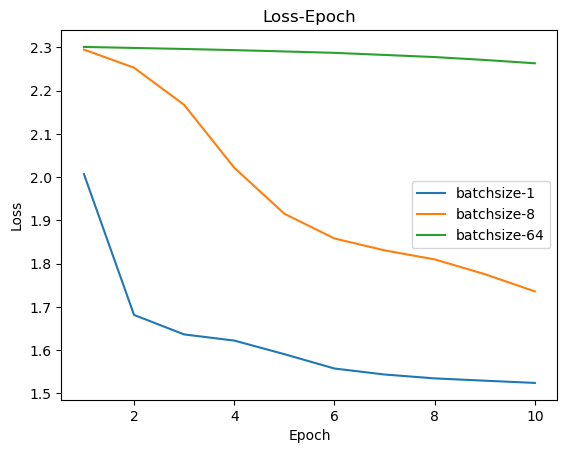

In [6]:
plt.figure()
plt.title('Loss-Epoch')
for batch_size in loss_by_epoch.keys():
    loss = loss_by_epoch[batch_size]
    plt.plot(range(1, max_epoch + 1), loss, label=f'batchsize-{batch_size}')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

We can see that the loss decreases fast if the batch size is small.
It means the model training is fast.

## Loss curve by iterations for various batch size

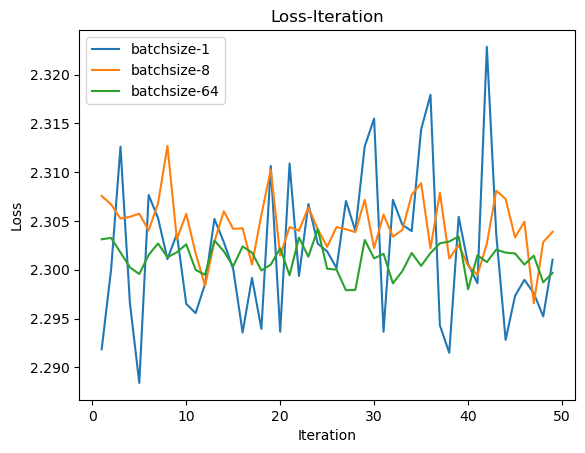

In [7]:
plt.figure()
plt.title('Loss-Iteration')
leading_iter = 50
for batch_size in loss_by_batch.keys():
    loss = loss_by_batch[batch_size]
    plt.plot(range(1, leading_iter),
             loss[:leading_iter - 1],
             label=f'batchsize-{batch_size}')

plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend()
plt.show()

We only focus on the first 100 iterations. 
We find that the loss function with a small learning size is unstable: some are large and some are small. 
If the batch size increase, the loss curve is stable.
In summary, the small batch size can speed up training but it is not stable.

## Moment

**Momentum** is an extension to the gradient descent optimization algorithm that allows the search to build inertia in a direction in the search space and overcome the oscillations of noisy gradients and coast across flat spots of the search space.

In PyTorch, we can update the gradient descent optimization algorithm to use momentum.
This can be achieved by updating the sgd optimizer to take a “momentum” argument that defines the amount of momentum used during the search.

In [8]:
def train_with_batchsize_moment(train_dataset,
                                batch_size,
                                device,
                                max_epoch=50,
                                momentum=0.9):
    train_avg_loss_by_epoch = []
    train_loss_by_batch = []
    train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=4)

    mlp = torch.nn.Sequential(nn.Flatten(start_dim=1, end_dim=-1),
                              torch.nn.Linear(784, 512), torch.nn.ReLU(),
                              torch.nn.Linear(512, 10),
                              torch.nn.Softmax(dim=1))

    # move the model to gpu
    mlp = mlp.to(device)

    lr = 0.01
    optimizer = torch.optim.SGD(mlp.parameters(), lr=lr, momentum=momentum)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(max_epoch):
        train_loss_epoch = []
        for i_batch, sample_batched in enumerate(train_dataloader):
            inputs, labels = sample_batched
            # move data to GPU
            inputs, labels = inputs.to(device), labels.to(device)

            prob_distr = mlp(inputs)
            loss = criterion(prob_distr, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss_epoch.append(loss.item())
            train_loss_by_batch.append(loss.item())

        train_avg_loss_by_epoch.append(np.mean(train_loss_epoch))

    return train_avg_loss_by_epoch, train_loss_by_batch

loss_by_epoch_momentum = {}
loss_by_batch_momentum = {}


Let us redo the batch size experiment.

In [9]:
for batch_size in [1, 8, 64]:
    loss_by_epoch_momentum[batch_size], loss_by_batch_momentum[
        batch_size] = train_with_batchsize_moment(train_dataset,
                                                  batch_size,
                                                  device,
                                                  max_epoch,
                                                  momentum=0.99)

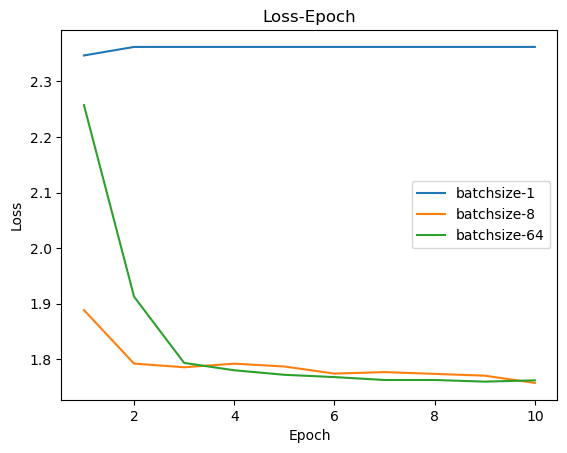

In [10]:
plt.figure()
plt.title('Loss-Epoch')
for batch_size in loss_by_epoch_momentum.keys():
    loss = loss_by_epoch_momentum[batch_size]
    plt.plot(range(1, max_epoch + 1), loss, label=f'batchsize-{batch_size}')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

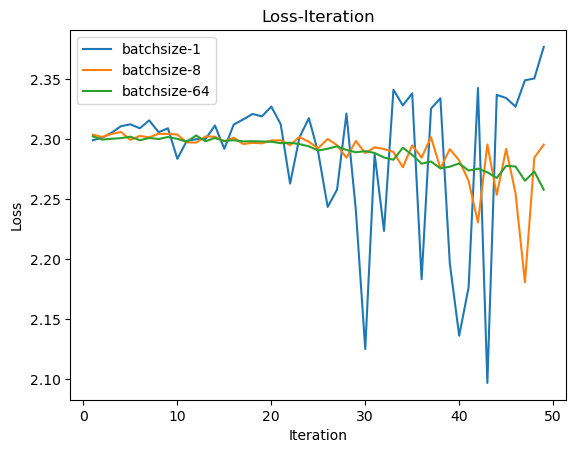

In [11]:
plt.figure()
plt.title('Loss-Iteration')
leading_iter = 50
for batch_size in loss_by_batch_momentum.keys():
    loss = loss_by_batch_momentum[batch_size]
    plt.plot(range(1, leading_iter),
             loss[:leading_iter - 1],
             label=f'batchsize-{batch_size}')

plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend()
plt.show()

As we can see, momentum increase on the training speed by increasing the stability of the gradient.

## Adam

We have discussed the adaptive learning rate and momentum seperately.
In deep learning, the **Adaptive Movement Estimation** algorithm, or **Adam** for short, is an extension to gradient descent and the adaptive learning rate for each input variable for the objective function and further smooths the search process by using an exponentially decreasing moving average of the gradient to make updates to variables.

In PyTorch, Adam is easy to use by replace the optimizer `SGD` with `Adam`.

```python
optimizer = optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False, *, foreach=None, maximize=False, capturable=False, differentiable=False, fused=False)
```

In [15]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=4)

mlp = nn.Sequential(nn.Flatten(start_dim=1, end_dim=-1),
                    torch.nn.Linear(784, 512), torch.nn.ReLU(),
                    torch.nn.Linear(512, 10), torch.nn.Softmax(dim=1))

# move the model to gpu
mlp = mlp.to(device)

lr = 0.01
# Adapt Adam
# beta1 is the exponential decay rate for the momentum term also called first moment estimates.
# It’s default value in PyTorch is 0.9.
# beta2 is the exponential decay rate for velocity term also called the second-moment estimates.
# The default value is 0.999 in the PyTorch implementation.
optimizer = torch.optim.Adam(mlp.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(max_epoch):
    train_loss_epoch = []
    for i_batch, sample_batched in enumerate(train_dataloader):
        inputs, labels = sample_batched
        # move data to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        prob_distr = mlp(inputs)
        loss = criterion(prob_distr, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(loss.item())

1.587829351425171
1.4611519575119019
1.4620656967163086
1.7058393955230713
1.4611502885818481
1.4611502885818481
1.4611502885818481
1.5861502885818481
1.4612103700637817
1.5874905586242676


## Summary

In this tutorial, you discovered the impact of batch size in SGD and how to improve the stablity of the learning curve with momentum.